# Halo Sampling in 21cmFAST

This short notebook will run through a few quick examples to show how the halo sampler works. We Will:
- draw halo samples from a density grid, and make sure they match the underlying mass function
- draw halo samples from a descendant catalogue, making sure they match both the expected unconditional mass function and respond to any deviations in the descendant catalogue
- create HII boxes and lightcones using these sources, seeing the effect of halo samples on reionization and cosmic dawn

When the HALO_STOCHASTICITY flag option is used, there are a few differences in the running of a lightcone or coeval box.
- At the lowest desired redshift, a limited version of the old halo finder runs the excursion set algorithm to find halos above the mass of the low-resolution grid cell (HII_DIM)
- Below this mass, and above some user-defined value (``SimulationOptions.SAMPLER_MIN_MASS``), we sample the conditional mass function in each grid cell to generate a population of halos, and sample their stellar mass and SFR from lognormal distributions
- The algorithm then steps backward in time, sampling progenitors using each descendant halo as the condition in the conditional mass function. This repeats until we have the halo catalogs at every timestep we wish to compute the reionization history for.
- When the algorithm steps forward in time to calculate ionization histories and spin temperatures, the halo catalogues at the desired redshifts are gridded, and if necessary we add the mean contribution of halos below the sampled mass to each grid cell (by simply integrating the CMF in that cell up to the sampled mass). These halo boxes contain the halo mass density, stellar mass density and star formation rate density which are directly used instead of the overdensity field when calculating the radiative backgrounds.

#### We import a few packages here for plotting and verification
##### For this exercise, we get reference mass functions from the [HMF package](https://github.com/halomod/hmf)

In [1]:
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize

import py21cmfast as p21c

plt.rcParams["figure.figsize"] = [16, 8]
from timeit import default_timer as timer

#we use the HMF package (github.com/halomod/hmf) to verify our outputs
from hmf import MassFunction
from powerbox import get_power

In [2]:
# We are using a relatively small box for this test
inputs = p21c.InputParameters.from_template(
    'latest-dhalos',
    random_seed=24,
).evolve_input_structs(
    SAMPLER_MIN_MASS=1e9,
    BOX_LEN=100,
    DIM=200,
    HII_DIM=50,
    USE_TS_FLUCT=False,
    INHOMO_RECO=False,
    HALOMASS_CORRECTION=1.,
    AVG_BELOW_SAMPLER=True,
    USE_EXP_FILTER=False,
    USE_UPPER_STELLAR_TURNOVER=False,
    CELL_RECOMB=False,
    R_BUBBLE_MAX=15.
).clone(
    node_redshifts=(8,10)
)

#set up some histogram parameters for plotting hmfs
edges = np.logspace(7, 13, num=64)
widths = np.diff(edges)
dlnm = np.log(edges[1:]) - np.log(edges[:-1])
centres = (edges[:-1] * np.exp(dlnm / 2)).astype("f4")
volume = inputs.simulation_options.BOX_LEN**3
little_h = inputs.cosmo_params.cosmo.H0.to("km s-1 Mpc-1") / 100

mf_pkg_st = MassFunction(
    z=inputs.node_redshifts[-1],
    Mmin=7,
    Mmax=15,
    cosmo_model=inputs.cosmo_params.cosmo,
    hmf_model="ST",
    hmf_params={"a": 0.73, "p": 0.175, "A": 0.353},
    transfer_model="EH",
)
mf_pkg_st2 = MassFunction(
    z=inputs.node_redshifts[-2],
    Mmin=7,
    Mmax=15,
    cosmo_model=inputs.cosmo_params.cosmo,
    hmf_model="ST",
    hmf_params={"a": 0.73, "p": 0.175, "A": 0.353},
    transfer_model="EH",
)

In [3]:
# create the initial conditions
init_box = p21c.compute_initial_conditions(
    inputs=inputs,
)

#### First, Run a single halo catalogue from the density grid and plot the resulting binned mass function
note that we go backward through the node redshifts

In [4]:
halolist_init = p21c.determine_halo_list(
    redshift=inputs.node_redshifts[-1],
    initial_conditions=init_box,
    inputs=inputs
)

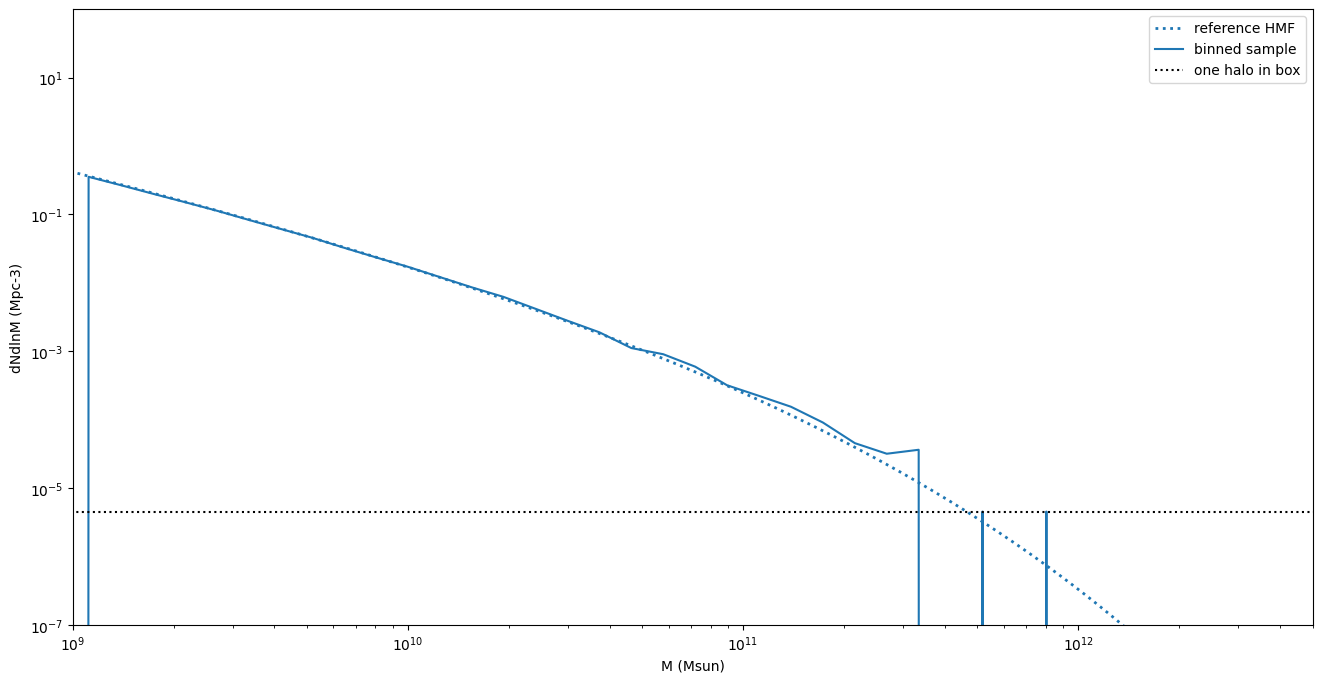

In [5]:
# get the mass function
masses = halolist_init.get('halo_masses')
hist, _ = np.histogram(masses, edges)
mf = hist / volume / dlnm
plt.loglog(
    mf_pkg_st.m / little_h,
    mf_pkg_st.dndlnm * (little_h**3),
    color="C0",
    linewidth=2,
    linestyle=":",
    label="reference HMF",
)
plt.loglog(centres, mf, color="C0", label="binned sample")
plt.loglog(centres, 1 / volume / dlnm, "k:", label="one halo in box")

plt.xlim([1e9, 5e12])
plt.ylim([1e-7, 1e2])
plt.ylabel("dNdlnM (Mpc-3)")
plt.xlabel("M (Msun)")
plt.legend()
plt.show()

##### Aside from very high mass halos where shot noise is important, Samples follow the expected mass function very closely

#### We can also sample from a previously calculated (descendant) halo list by specifying a new redshift

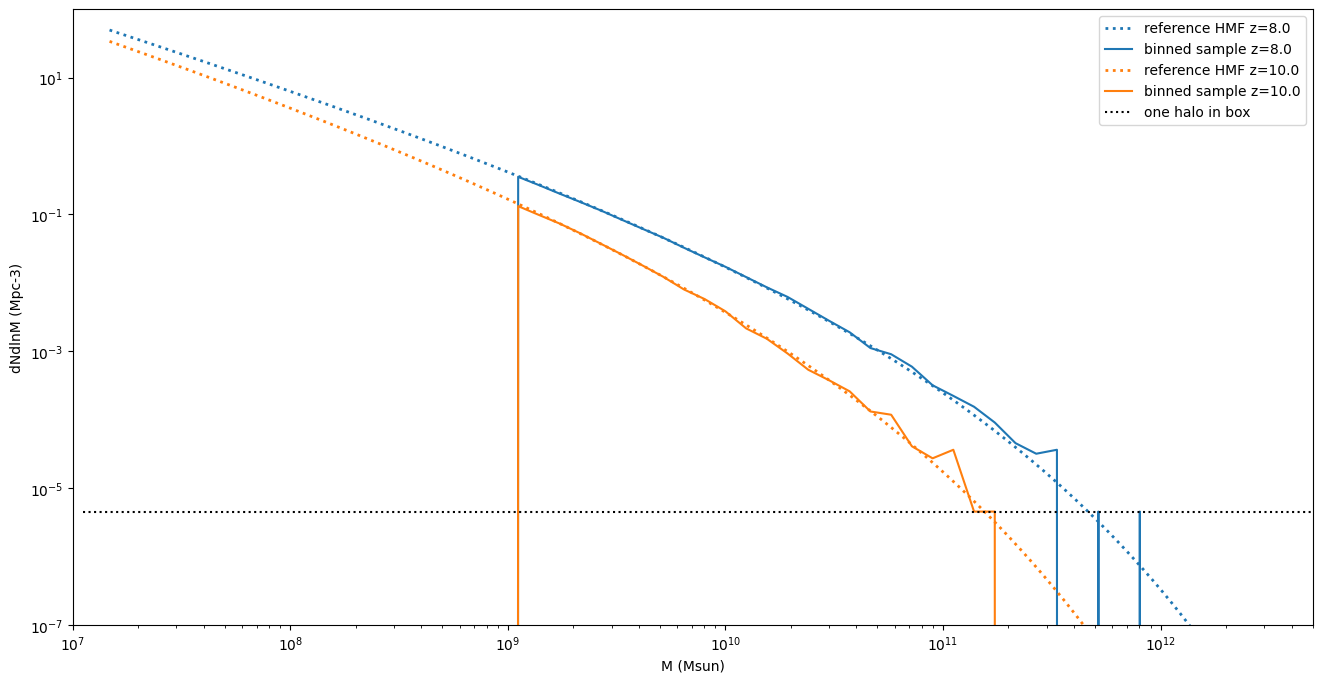

In [6]:
halolist_next = p21c.determine_halo_list(
    redshift=inputs.node_redshifts[-2],
    initial_conditions=init_box,
    descendant_halos=halolist_init
)
# get the mass function
masses = halolist_next.get('halo_masses')
hist, _ = np.histogram(masses, edges)
mf2 = hist / volume / dlnm
plt.loglog(
    mf_pkg_st.m / little_h,
    mf_pkg_st.dndlnm * (little_h**3),
    color="C0",
    linewidth=2,
    linestyle=":",
    label=f"reference HMF z={halolist_init.redshift}",
)
plt.loglog(centres, mf, color="C0", label=f"binned sample z={halolist_init.redshift}")

plt.loglog(
    mf_pkg_st2.m / little_h,
    mf_pkg_st2.dndlnm * (little_h**3),
    color="C1",
    linewidth=2,
    linestyle=":",
    label=f"reference HMF z={halolist_next.redshift}",
)
plt.loglog(centres, mf2, color="C1", label=f"binned sample z={halolist_next.redshift}")
plt.loglog(centres, 1 / volume / dlnm, "k:", label="one halo in box")

plt.xlim([1e7, 5e12])
plt.ylim([1e-7, 1e2])
plt.ylabel("dNdlnM (Mpc-3)")
plt.xlabel("M (Msun)")
plt.legend()
plt.show()

##### Results for the next redshift follow the mass function at z=10, even through they are not explicitly given this mass function

#### If we modify the descendant halo list, we can see how descendant halos effect the progenitor population
In this case, we add 1000 halos of mass 1e11 to see what happens to the progenitor population

In [7]:
#Adjusting values of an OutputStruct is not typically done, but we need to for this demonstration
halolist_edit = p21c.HaloField.new(redshift=halolist_init.redshift,inputs=inputs)
edited_mass = halolist_init.get('halo_masses')
edited_mass[halolist_init.n_halos : halolist_init.n_halos + 1000] = 1e11
halolist_edit.n_halos = halolist_init.n_halos + 1000
halolist_edit.halo_masses = halolist_init.halo_masses.with_value(edited_mass)
halolist_edit.halo_coords = halolist_init.halo_coords
halolist_edit.star_rng = halolist_init.star_rng
halolist_edit.sfr_rng = halolist_init.sfr_rng
halolist_edit.xray_rng = halolist_init.xray_rng

halolist_next2 = p21c.determine_halo_list(
    redshift=halolist_next.redshift,
    descendant_halos=halolist_edit,
    initial_conditions=init_box,
    regenerate=True
)

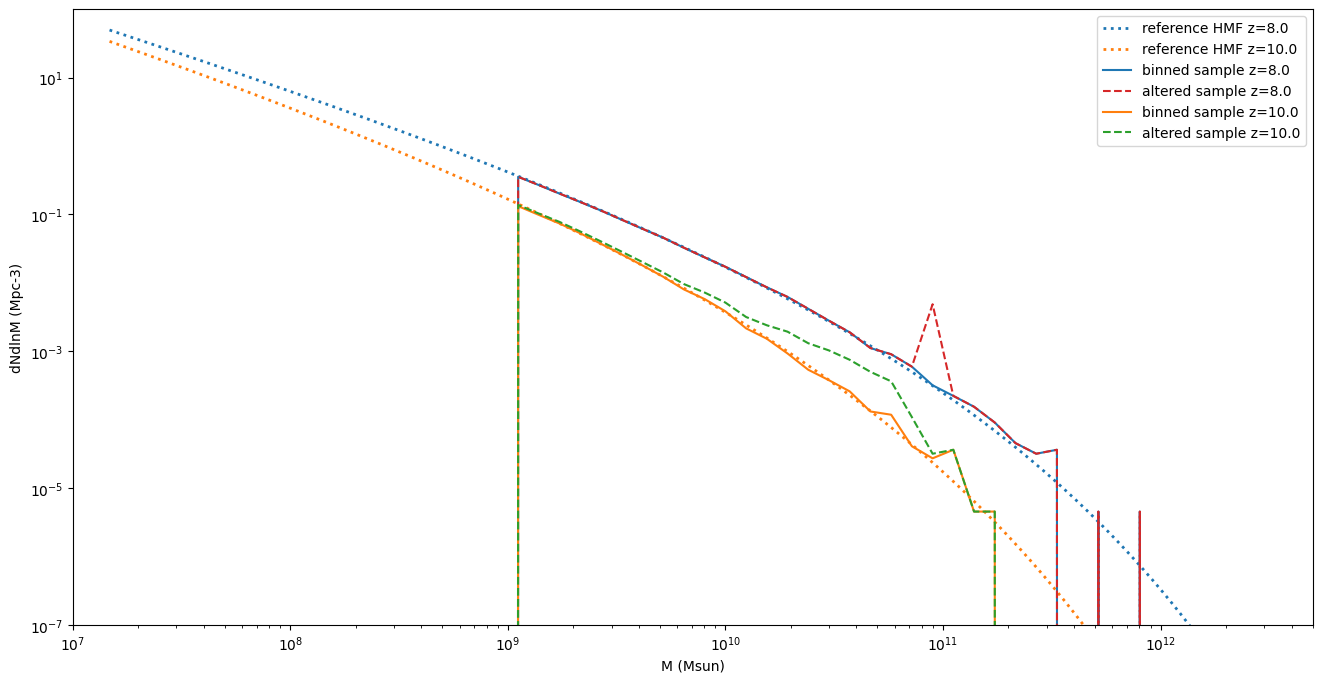

In [8]:
# get the mass functions
masses = halolist_next2.get('halo_masses')
hist, _ = np.histogram(masses, edges)
mf3 = hist / volume / dlnm

masses = halolist_edit.get('halo_masses')
hist, _ = np.histogram(masses, edges)
mf4 = hist / volume / dlnm

plt.loglog(
    mf_pkg_st.m / little_h,
    mf_pkg_st.dndlnm * (little_h**3),
    color="C0",
    linewidth=2,
    linestyle=":",
    label=f"reference HMF z={halolist_init.redshift}",
)
plt.loglog(
    mf_pkg_st2.m / little_h,
    mf_pkg_st2.dndlnm * (little_h**3),
    color="C1",
    linewidth=2,
    linestyle=":",
    label=f"reference HMF z={halolist_next.redshift}",
)

plt.loglog(centres, mf, color="C0", label=f"binned sample z={halolist_init.redshift}")
plt.loglog(
    centres, mf4, color="C3", linestyle="--", label=f"altered sample z={halolist_init.redshift}"
)


plt.loglog(centres, mf2, color="C1", label=f"binned sample z={halolist_next.redshift}")

plt.loglog(
    centres,
    mf3,
    color="C2",
    linestyle="--",
    label=f"altered sample z={halolist_next.redshift}",
)

plt.xlim([1e7, 5e12])
plt.ylim([1e-7, 1e2])
plt.ylabel("dNdlnM (Mpc-3)")
plt.xlabel("M (Msun)")
plt.legend()
plt.show()

##### The alteration in the descendant catalogue (red dashed line) is reflected in its progenitors (green dashed line)
We see an increase in higher mass halos just underneath the added descendant mass of 1e11

#### HALO CATALOGUES CAN BE PERTURBED AND GRIDDED
- When we perturb the halo list, it moves from the Lagrangian initial condition coordinates onto the Eulerian coordinates at the desired redshift
- the HaloBox class stores the gridded quantities (halo mass, stellar mass, star formation rate) of the halo catalogues, which are used for calculating the radiative backgrounds

In [9]:
# This function moves the halos from the initial condition grid onto the real grid at the given redshift
pt_halos = p21c.perturb_halo_list(
    halo_field=halolist_init, initial_conditions=init_box
)

In [10]:
# This function sums halo proprties within each cell to create grids of halo mass, stellar mass, star formation rate and more

pt_field = p21c.perturb_field(
    initial_conditions=init_box,
    redshift=pt_halos.redshift,
)
halo_box = p21c.compute_halo_grid(perturbed_field=pt_field, perturbed_halo_list=pt_halos, initial_conditions=init_box)

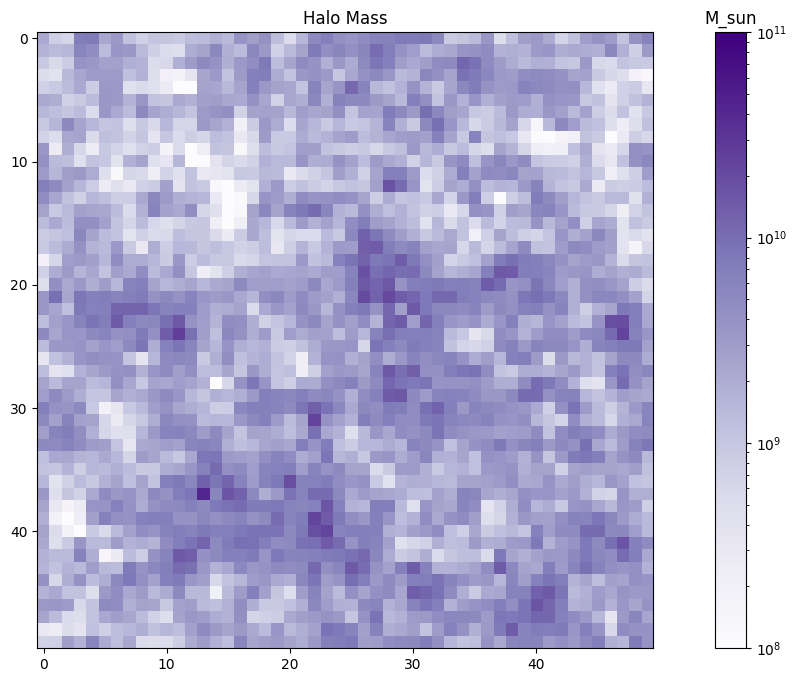

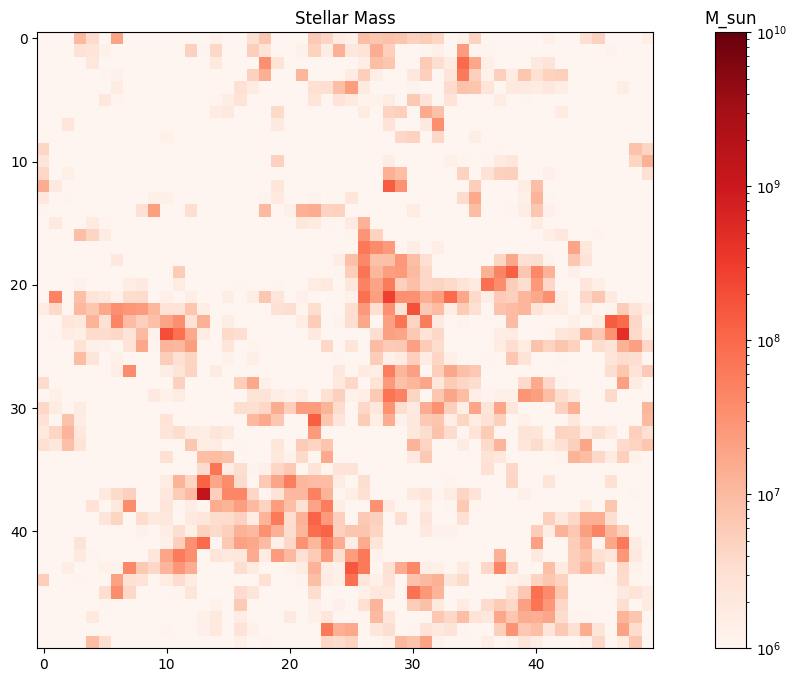

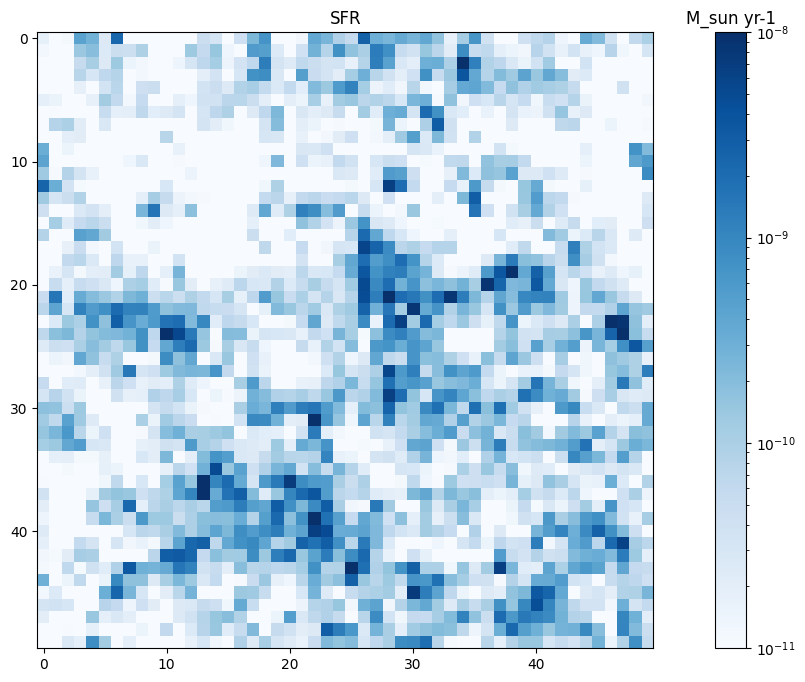

In [11]:
plt.figure()
plt.imshow(
    halo_box.get('halo_mass')[..., 0], cmap=cm.Purples, norm=LogNorm(vmin=1e8, vmax=1e11)
)
plt.title("Halo Mass")
cb = plt.colorbar()
cb.ax.set_title("M_sun")
plt.show()
plt.imshow(halo_box.get('halo_stars')[..., 0], cmap=cm.Reds, norm=LogNorm(vmin=1e6, vmax=1e10))
plt.title("Stellar Mass")
cb = plt.colorbar()
cb.ax.set_title("M_sun")
plt.show()
plt.imshow(
    halo_box.get('halo_sfr')[..., 0], cmap=cm.Blues, norm=LogNorm(vmin=1e-11, vmax=1e-8)
)
plt.title("SFR")
cb = plt.colorbar()
cb.ax.set_title("M_sun yr-1")
plt.show()

We expect halo mass, stellar mass and SFR to follow a very similar distribution, as all are dependent on the density field

#### These grids can be used instead of the density field when calculating HII maps or spin temperatures

{}
{}
{}
{}
{}


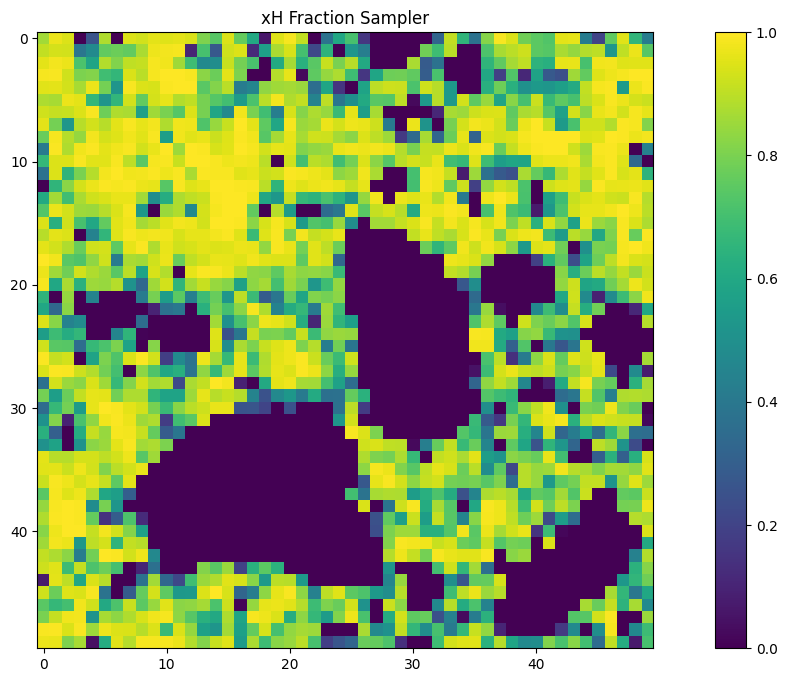

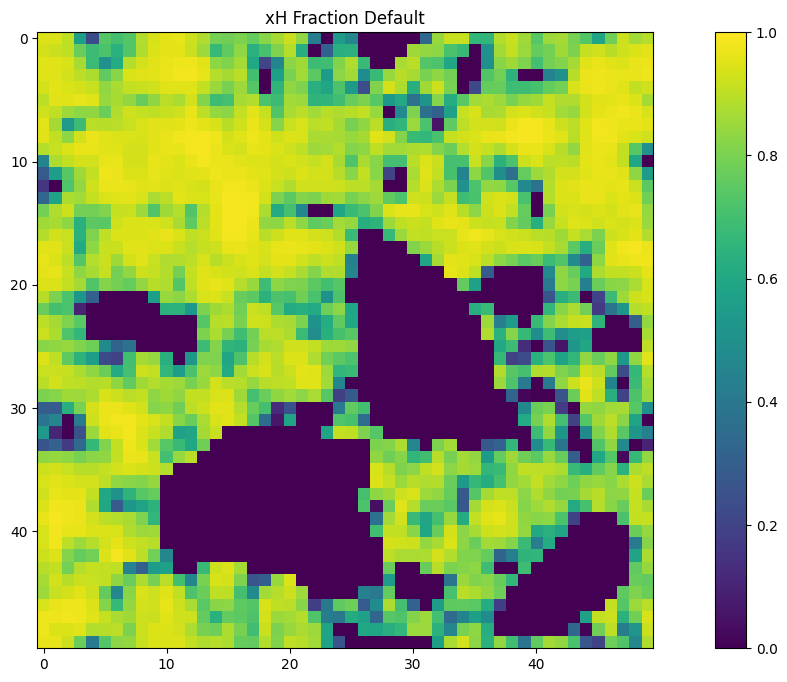

In [12]:
# passing a halo box into this function (with the USE_HALO_FIELD flag) will
# use the gridded halos instead of the density field to determine ionizing radiation
inputs_nosampler = inputs.evolve_input_structs(
    HALO_STOCHASTICITY=False,
    USE_HALO_FIELD=False,
)
inputs_nosampler2 = p21c.InputParameters.from_template(
    'simple',
    random_seed=inputs.random_seed,
    node_redshifts=inputs.node_redshifts,
).evolve_input_structs(HII_DIM=50,DIM=200,BOX_LEN=100,SAMPLER_MIN_MASS=1e9,HII_FILTER='spherical-tophat',HALOMASS_CORRECTION=1.)
print({k:(x,y) for (k,x),(i,y) in zip(inputs_nosampler.cosmo_params.cdict.items(), inputs_nosampler2.cosmo_params.cdict.items()) if x!=y})
print({k:(x,y) for (k,x),(i,y) in zip(inputs_nosampler.simulation_options.cdict.items(), inputs_nosampler2.simulation_options.cdict.items()) if x!=y})
print({k:(x,y) for (k,x),(i,y) in zip(inputs_nosampler.matter_options.cdict.items(), inputs_nosampler2.matter_options.cdict.items()) if x!=y})
print({k:(x,y) for (k,x),(i,y) in zip(inputs_nosampler.astro_params.cdict.items(), inputs_nosampler2.astro_params.cdict.items()) if x!=y})
print({k:(x,y) for (k,x),(i,y) in zip(inputs_nosampler.astro_options.cdict.items(), inputs_nosampler2.astro_options.cdict.items()) if x!=y})
inputs_nosampler = inputs_nosampler2
ic_nosampler = p21c.compute_initial_conditions(
    inputs=inputs_nosampler,
)
pt_field_nosampler = p21c.perturb_field(
    redshift=halo_box.redshift,
    initial_conditions=ic_nosampler,
)
ionbox_nosampler = p21c.compute_ionization_field(
    initial_conditions=ic_nosampler,
    perturbed_field=pt_field_nosampler,
    inputs=inputs_nosampler,
)
ionbox = p21c.compute_ionization_field(
    initial_conditions=init_box,
    perturbed_field=pt_field,
    halobox=halo_box,
)


plt.figure()
plt.imshow(ionbox.get('neutral_fraction')[..., 0], cmap=cm.viridis, norm=Normalize(vmin=0, vmax=1))
plt.title("xH Fraction Sampler")
plt.colorbar()
plt.show()
plt.imshow(
    ionbox_nosampler.get('neutral_fraction')[..., 0], cmap=cm.viridis, norm=Normalize(vmin=0, vmax=1)
)
plt.title("xH Fraction Default")
plt.colorbar()
plt.show()

The ionisation field is much noisier on small scales due to much larger variation in stellar mass. but follows the same distribution

#### Full lightcone run with / without stochastic halos (takes ~2 minutes to run through fully)

In [13]:
from tempfile import mkdtemp
cache = p21c.OutputCache(mkdtemp())
cacheconfig = p21c.CacheConfig.last_step_only()
inputs = inputs.clone(node_redshifts=p21c.get_logspaced_redshifts(min_redshift=6.,max_redshift=18.,z_step_factor=1.1))
inputs_nosampler = inputs_nosampler.clone(node_redshifts=p21c.get_logspaced_redshifts(min_redshift=6.,max_redshift=18.,z_step_factor=1.1))
lightcone_quantities = ["density", "neutral_fraction", "brightness_temp"]

lcn = p21c.RectilinearLightconer.with_equal_cdist_slices(
        min_redshift=min(inputs.node_redshifts),
        max_redshift=max(inputs.node_redshifts),
        quantities=lightcone_quantities,
        resolution=inputs.simulation_options.cell_size,
    )

_,_,_,lc = p21c.run_lightcone(
    lightconer=lcn,
    inputs=inputs,
    global_quantities=lightcone_quantities,
    cache=cache,
    write=cacheconfig,
)

_,_,_,lc_nosampler = p21c.run_lightcone(
    lightconer=lcn,
    inputs=inputs_nosampler,
    global_quantities=lightcone_quantities,
    cache=cache,
    write=cacheconfig,
)

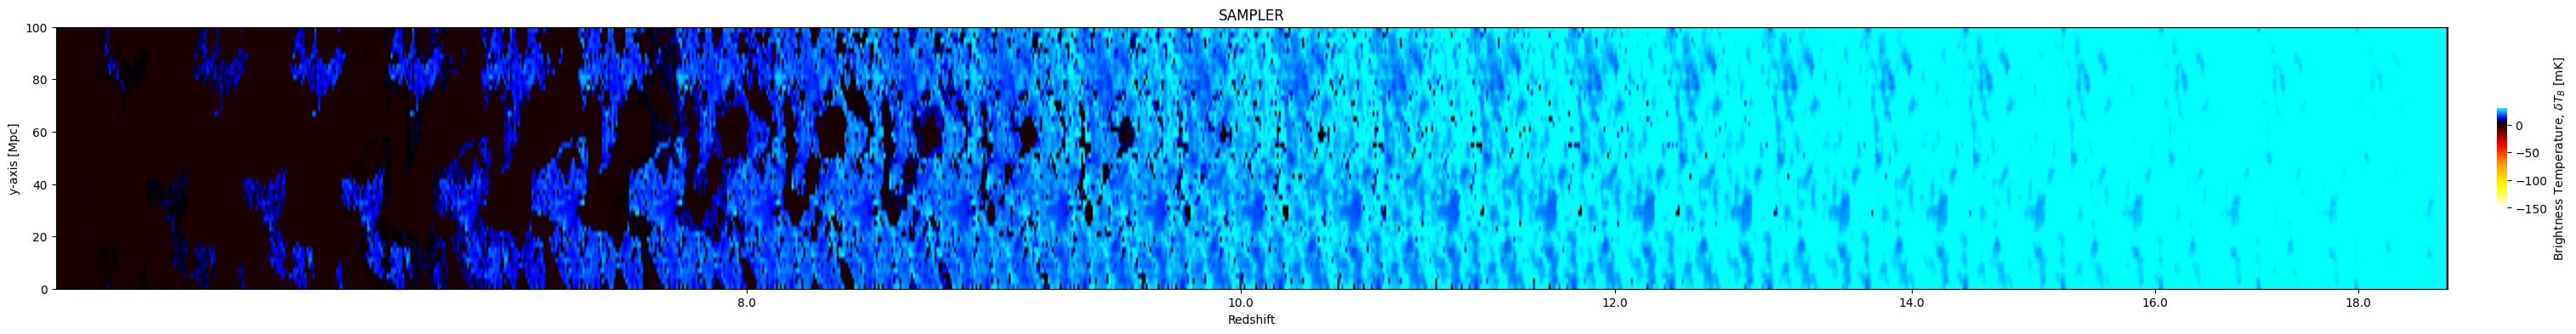

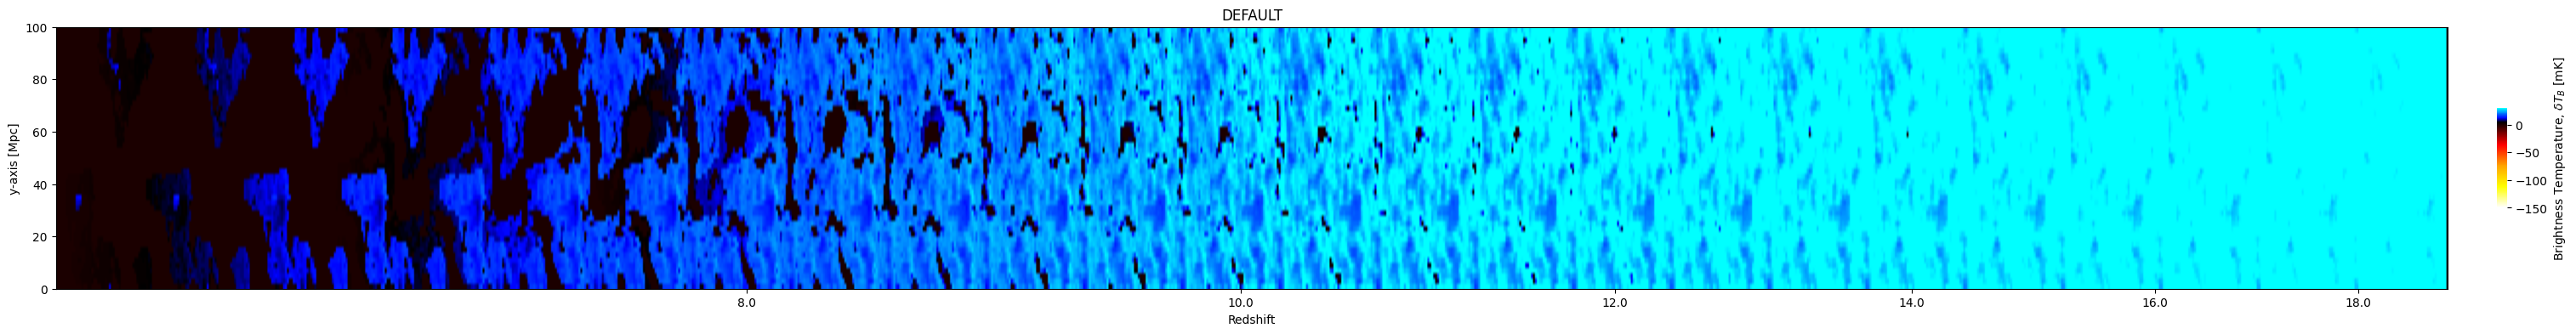

In [14]:
for l, title in zip([lc, lc_nosampler], ["SAMPLER", "DEFAULT"], strict=True):
    plot_shape = l.shape[::-1]
    fig, ax = plt.subplots(
        1,
        1,
        figsize=(
            plot_shape[0] * 0.03 + 0.5,
            plot_shape[1] * 0.06 + 1.0,
        ),
    )

    p21c.plotting.lightcone_sliceplot(
        l,
        kind='brightness_temp',
        zticks="redshift",
        aspect="auto",
        fig=fig,
        ax=ax,
        log=False,
        vertical=False,
        cbar_horizontal=False,
        slice_index=24,
    )
    ax.set_title(title)
    plt.show()

#### Examining the global brightness temperature and neutral fraction
The global results should be very similar, However differences can occur due to the varying occurrence of rare objects at high redshift, especially at smaller box sizes. It should also be noted that the mean fixing (in both ionizing emissivity and star formation rate density) which occurs in default 21cmFAST is not possible with the halo model, since it would cause the radiative source terms to be incompatible with the halo catalogs

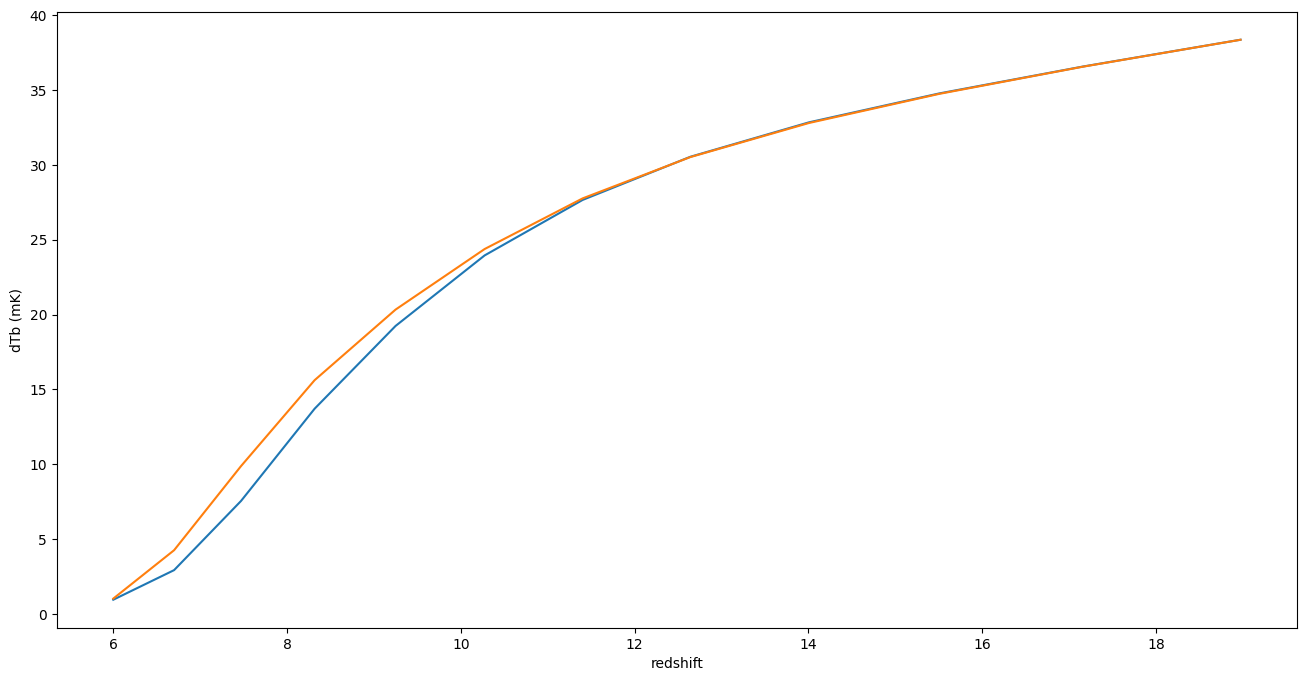

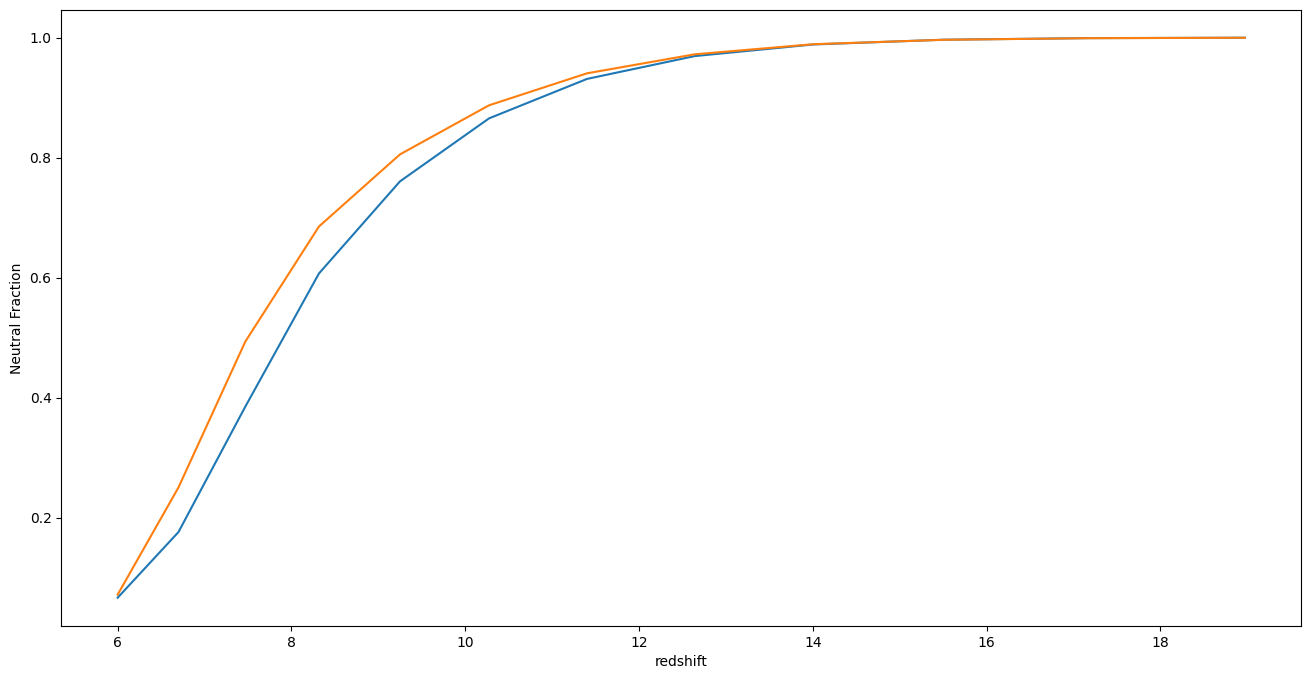

In [15]:
plt.figure()
plt.plot(lc.inputs.node_redshifts, lc.global_quantities['brightness_temp'])
plt.plot(lc_nosampler.inputs.node_redshifts, lc_nosampler.global_quantities['brightness_temp'])
plt.xlabel("redshift")
plt.ylabel("dTb (mK)")
plt.show()

plt.figure()
plt.plot(lc.inputs.node_redshifts, lc.global_quantities['neutral_fraction'])
plt.plot(lc_nosampler.inputs.node_redshifts, lc_nosampler.global_quantities['neutral_fraction'])
plt.xlabel("redshift")
plt.ylabel("Neutral Fraction")
plt.show()

#### Examining the 1D power spectra around z=12
We should see an increase variation, especially at small scales due to the shot-noise induced by halo fluctuations

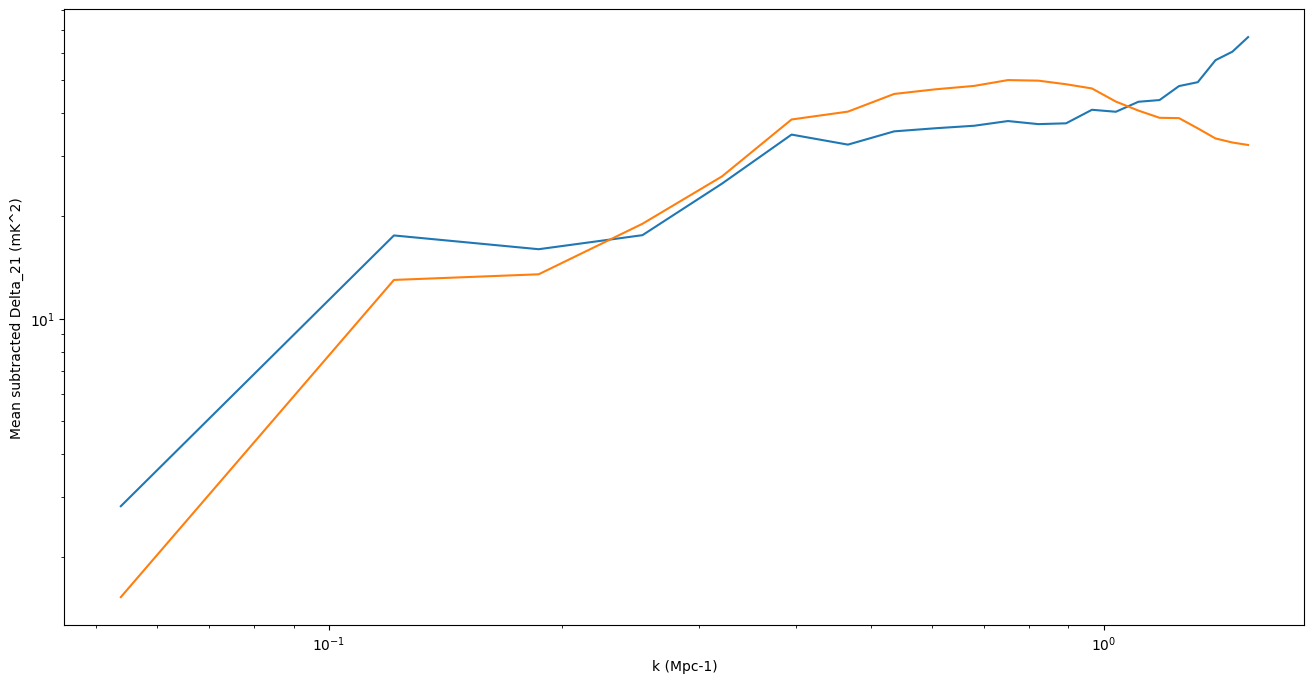

In [16]:
z_plot = 12
z_idx = np.argmin(np.fabs(lc.lightcone_redshifts - z_plot))
box_len = lc.simulation_options.BOX_LEN
grid_dim = lc.simulation_options.HII_DIM

# select the chunk we want to make the power spectrum from
lc_chunk = lc.lightcones['brightness_temp'][
    ..., z_idx - int(grid_dim / 2) : z_idx + int(grid_dim / 2)
]

# subtract the means in each slice
lc_chunk = lc_chunk - lc_chunk.mean(axis=(0, 1))[None, None, :]
chunk_dim = np.array(lc_chunk.shape) * box_len / grid_dim

# get the power using powerbox
p, k = get_power(lc_chunk, boxlength=chunk_dim)

lc_chunk_nosampler = lc_nosampler.lightcones['brightness_temp'][
    ..., z_idx - int(grid_dim / 2) : z_idx + int(grid_dim / 2)
]
lc_chunk_nosampler = (
    lc_chunk_nosampler - lc_chunk_nosampler.mean(axis=(0, 1))[None, None, :]
)
p2, k2 = get_power(lc_chunk_nosampler, boxlength=chunk_dim)

plt.figure()
plt.loglog(k, p * k**3 / (np.pi * 2))
plt.loglog(k2, p2 * k2**3 / (np.pi * 2))
plt.xlabel("k (Mpc-1)")
plt.ylabel("Mean subtracted Delta_21 (mK^2)")
plt.show()